In [36]:
import numpy as np
import math
SIMULATION_TIME = 20.0
delta_t = 0.1

v = 1.0
yawrate = 0.2
# Fix u throughout simulation
u = np.array([[v,yawrate]]).T

# State Vector [x y yaw v]'
estimated_state_mean = np.zeros((4,1))
estimated_state_covariance = np.eye(4)
true_state = np.zeros((4,1))

R = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
Q = np.diag([1.0, 1.0])**2  # Observation x,y position covariance
Qsim = np.diag([0.5, 0.5])**2 # Inherent sensor noise
history_estimated_state = np.zeros((4,1))
history_true_state = np.zeros((4,1))
history_measurements = np.zeros((2,1))

In [37]:
def motion_model(x,u):
    A = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[delta_t * math.cos(x[2, 0]), 0],
                  [delta_t * math.sin(x[2, 0]), 0],
                  [0.0, delta_t],
                  [1.0, 0.0]])

    x_ = A@x + B@u

    return x_

def jacobian(x,u):
    """
    Jacobian of Motion Model

    __motion model__
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    ---
    __partial derivatives__
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    dx/dt = 1
    dy/dt = 1
    dyaw/dt = 1
    """
    yaw = x[2, 0]
    v = u[0, 0]
    J = np.array([
        [1.0, 0.0, -delta_t*v*math.sin(yaw), delta_t*math.cos(yaw)],
        [0.0, 1.0, v*delta_t*math.cos(yaw), delta_t*math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ])
    return J

# No need to create a function for Measurement Jacobian.
# It is constant for all cases.
# Also Measurement Jacobian and Measurement Matrice is equivalent.
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])


In [38]:
def ekf(estimated_state_mean,estimated_state_covariance,u,z):
    # prediction
    pred_state_mean = motion_model(estimated_state_mean,u)
    G = jacobian(pred_state_mean,u)
    pred_state_covariance = G@estimated_state_covariance@G.T + R

    # measurement update
    zpred = H@pred_state_mean
    pred_measurement_covariance = H.dot(pred_state_covariance).dot(H.T) + Q
    kalman_gain = pred_state_covariance@H.T@np.linalg.inv(pred_measurement_covariance)
    estimated_state_mean = pred_state_mean + kalman_gain@(z-zpred)
    estimated_state_covariance = (np.eye(len(estimated_state_mean)) - kalman_gain@H)@pred_state_covariance
    return estimated_state_mean,estimated_state_covariance

In [39]:
def plot_covariance_ellipse(mu,sigma):
    Sigma_xy = sigma[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Sigma_xy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R@(np.array([x, y]))
    px = np.array(fx[0, :] + mu[0, 0]).flatten()
    py = np.array(fx[1, :] + mu[1, 0]).flatten()
    plt.plot(px, py, "--r")

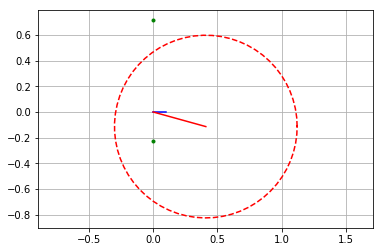

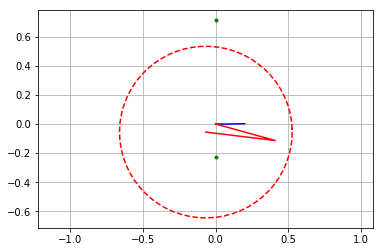

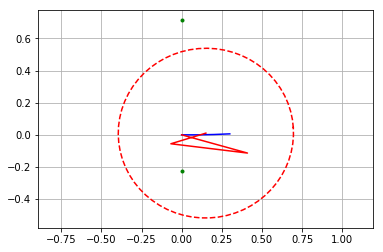

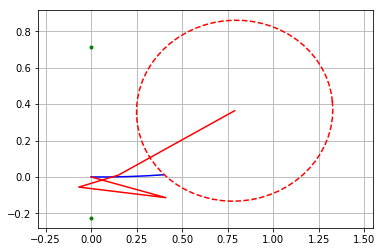

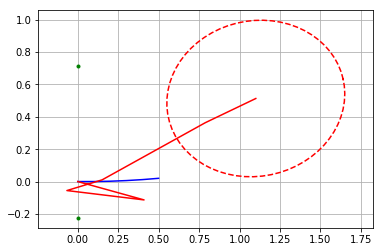

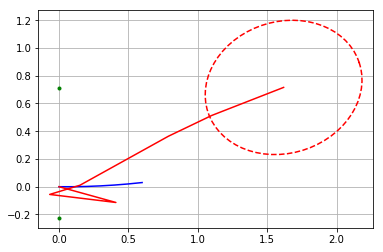

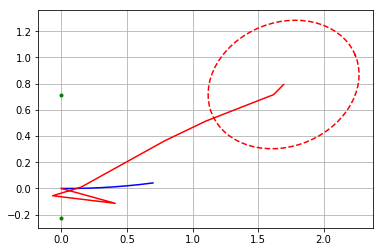

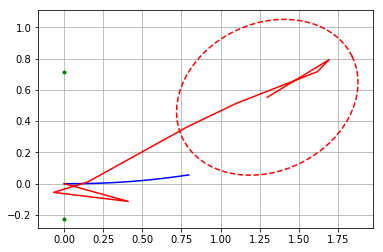

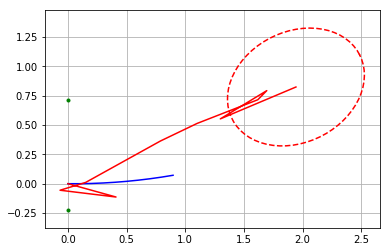

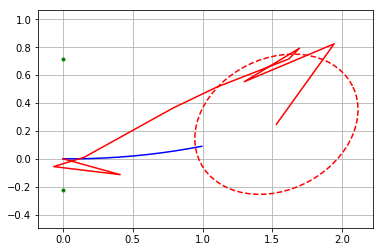

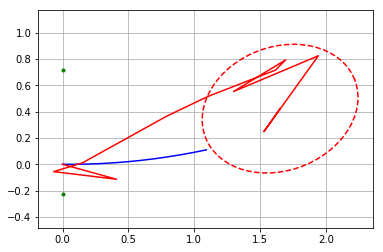

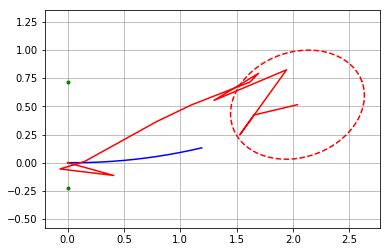

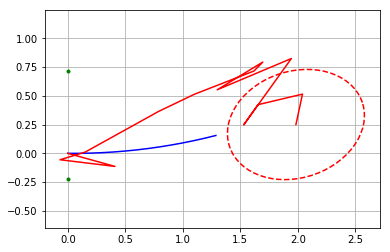

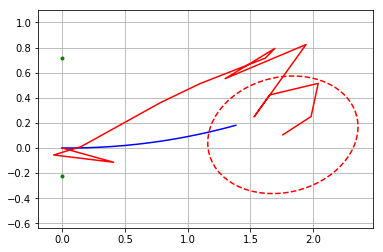

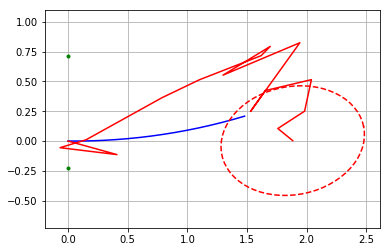

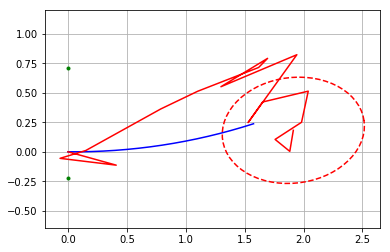

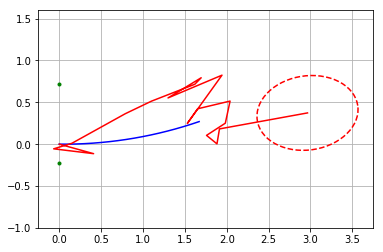

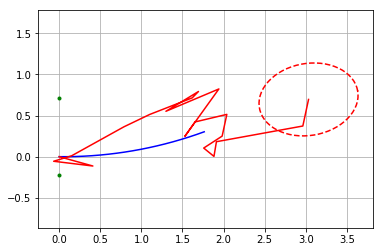

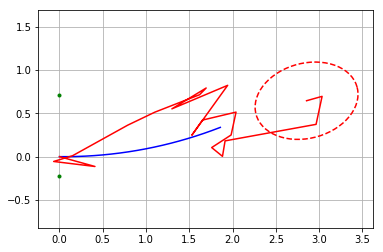

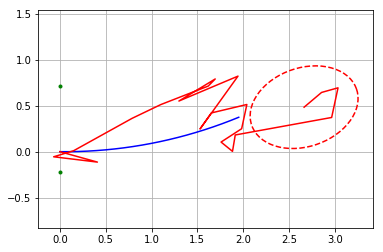

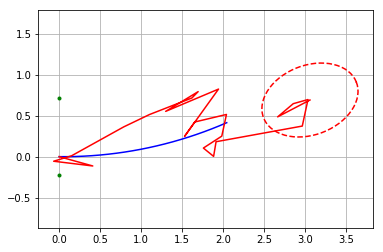

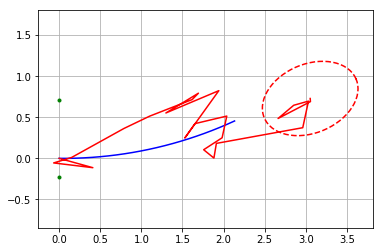

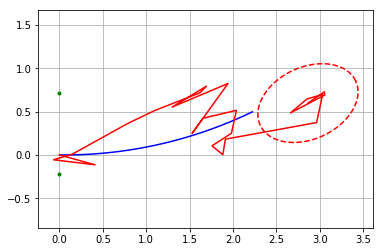

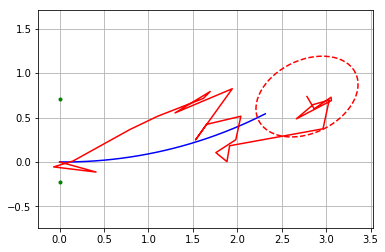

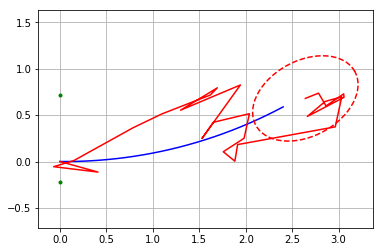

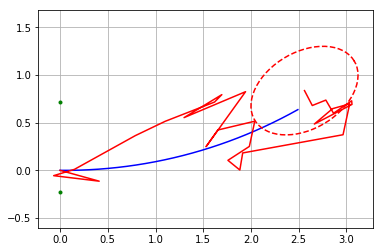

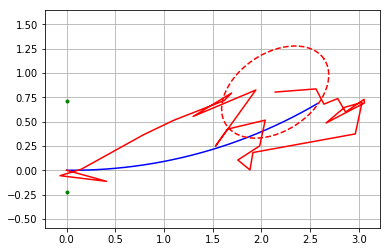

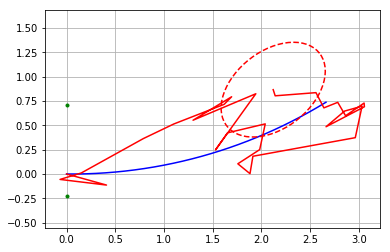

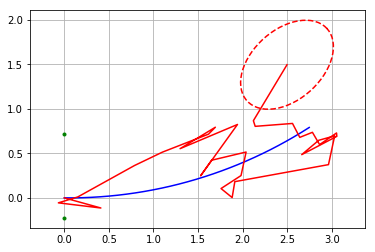

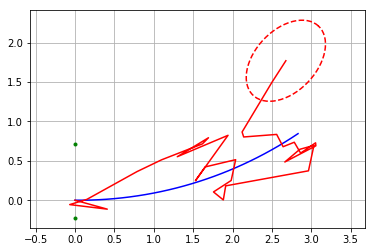

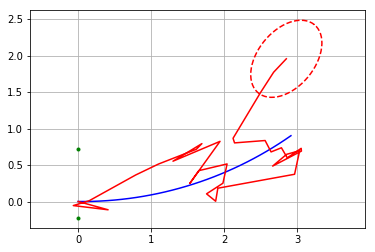

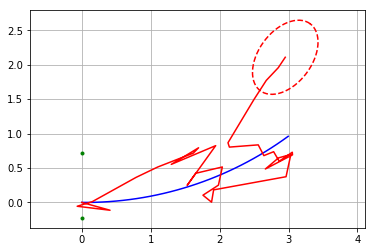

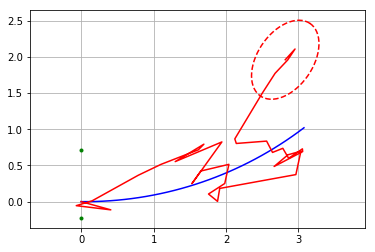

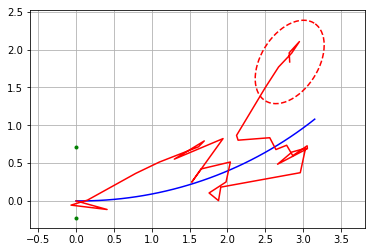

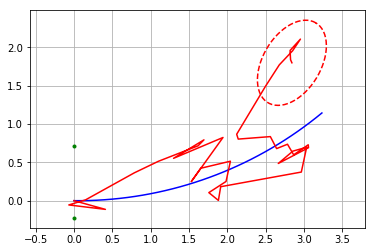

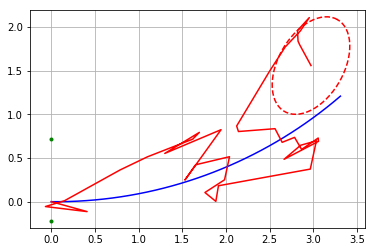

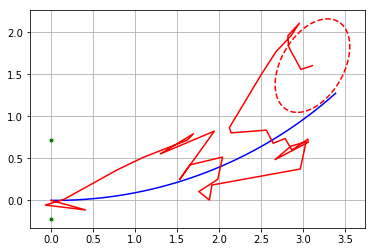

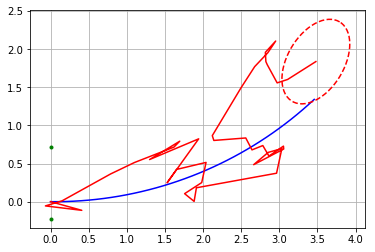

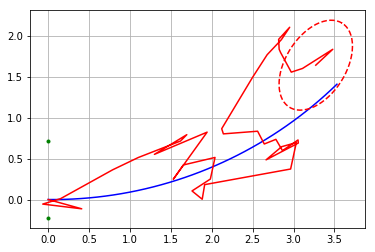

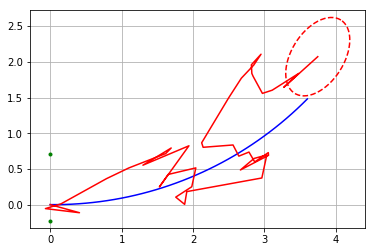

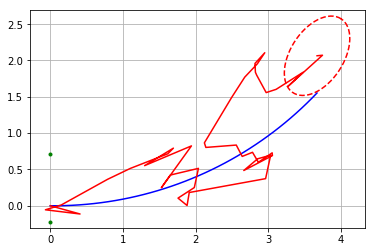

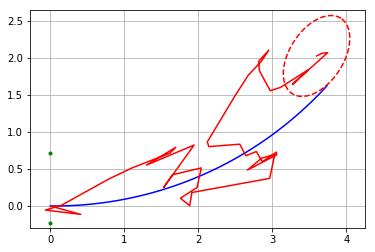

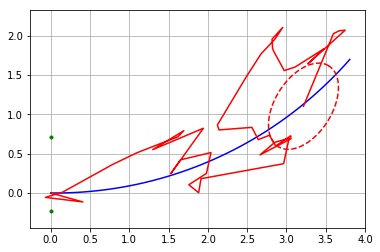

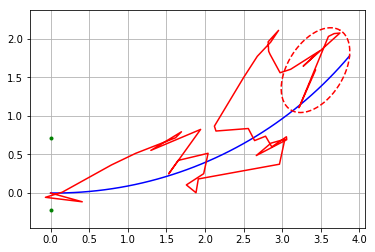

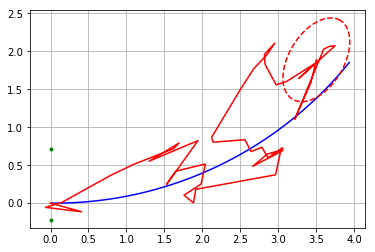

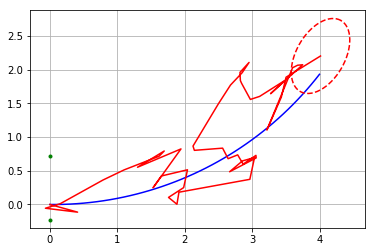

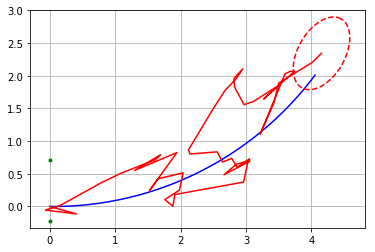

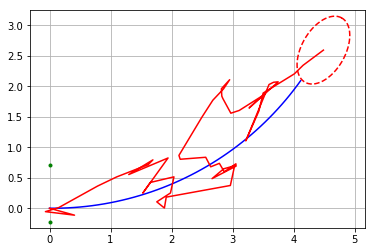

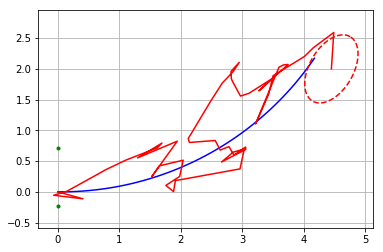

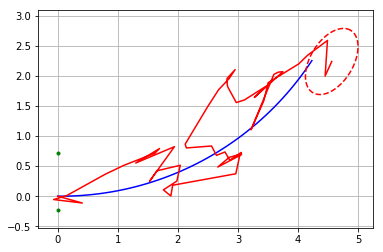

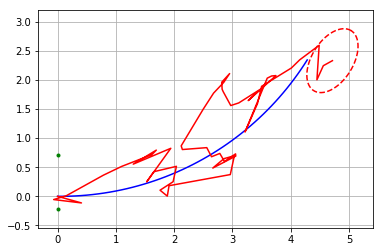

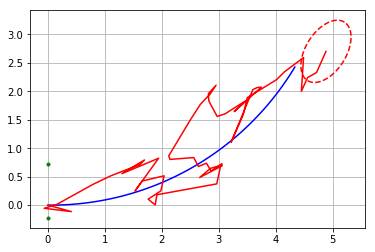

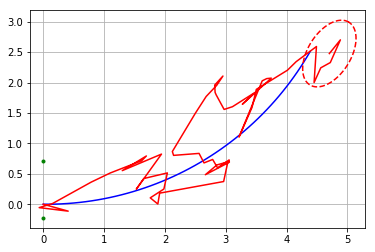

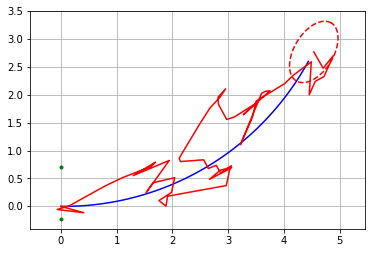

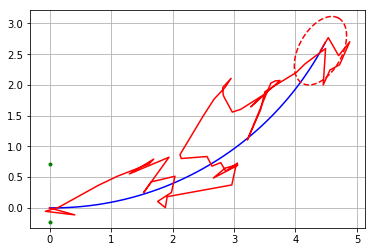

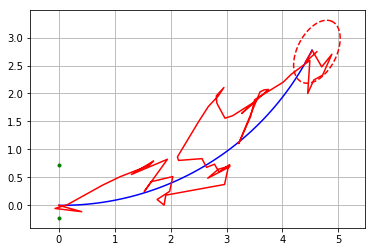

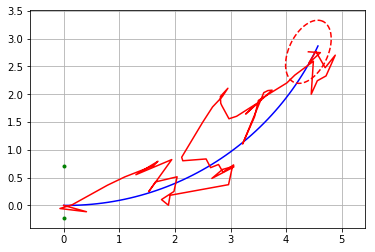

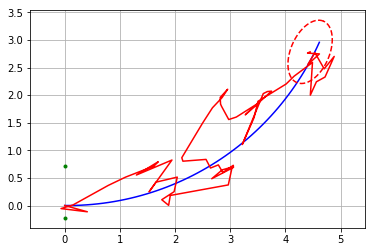

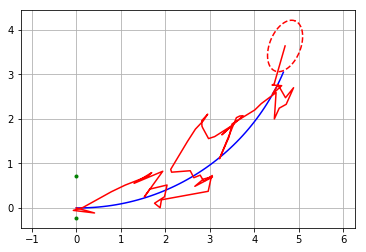

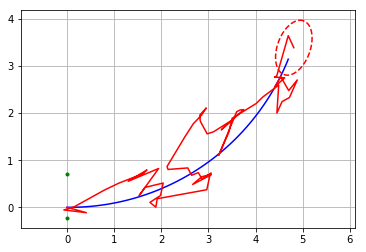

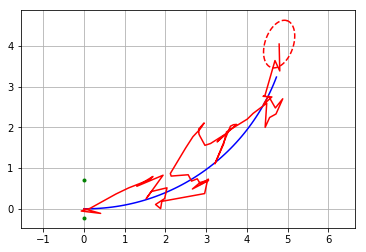

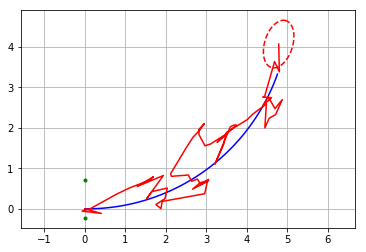

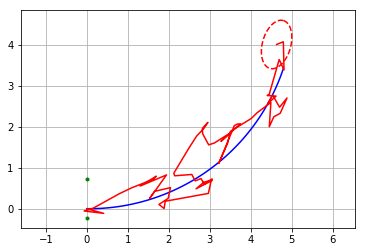

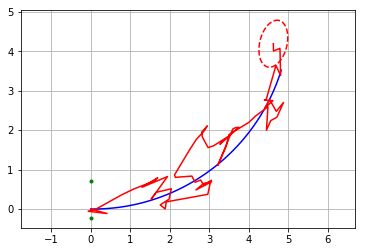

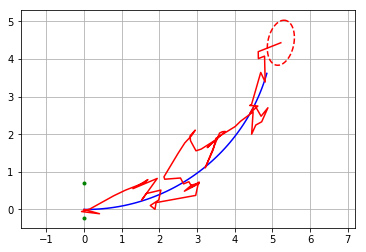

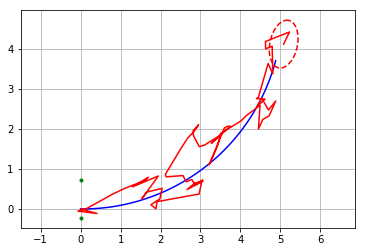

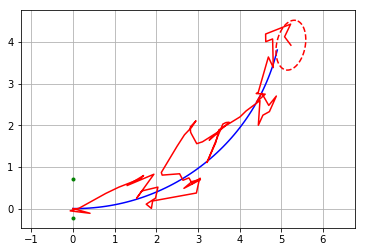

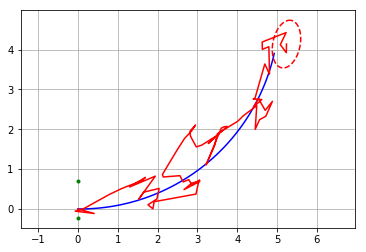

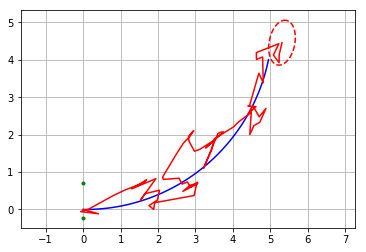

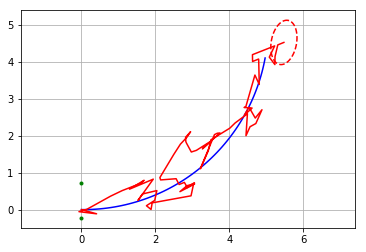

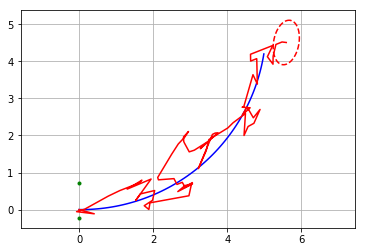

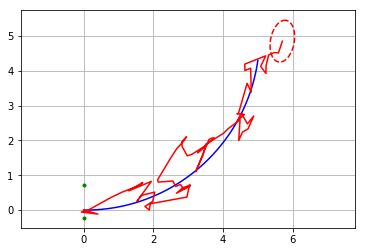

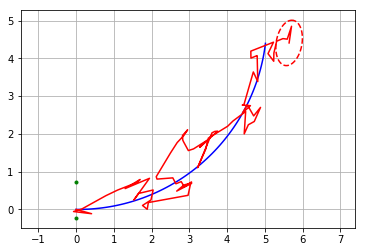

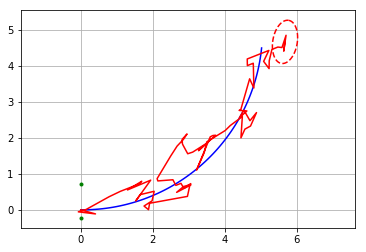

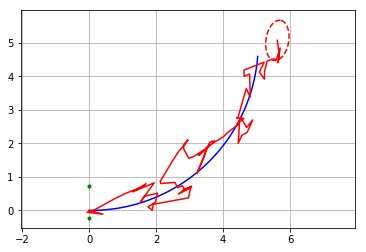

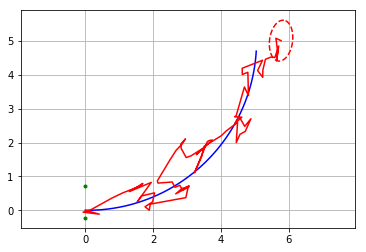

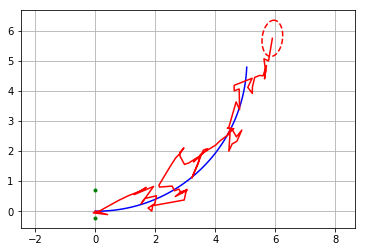

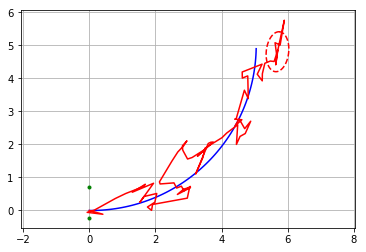

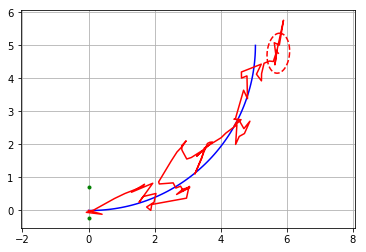

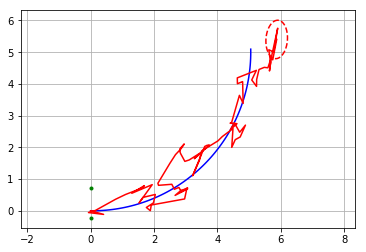

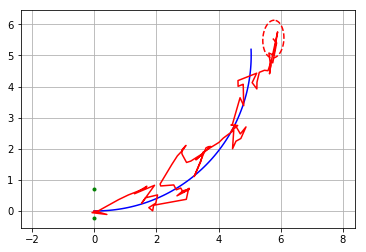

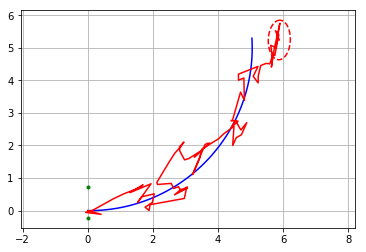

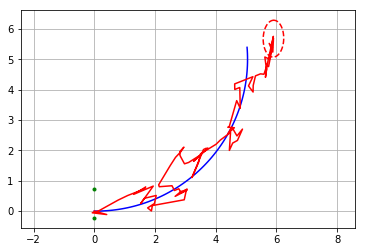

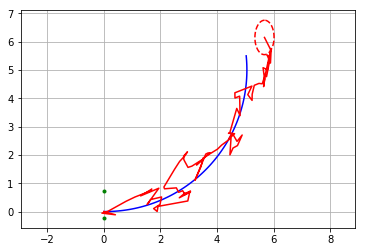

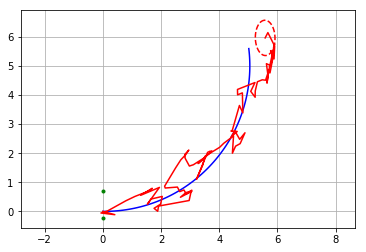

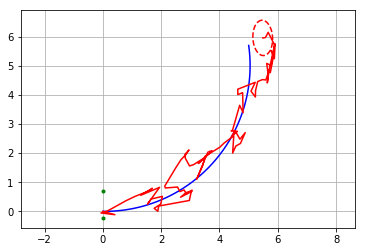

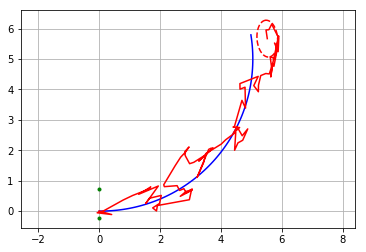

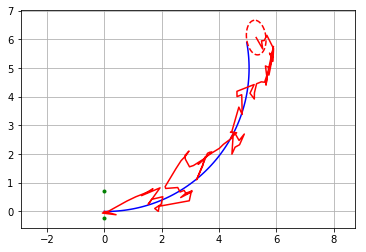

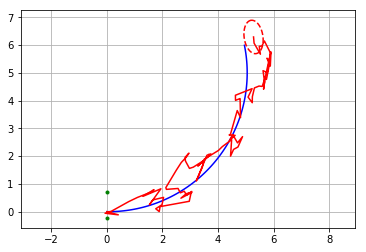

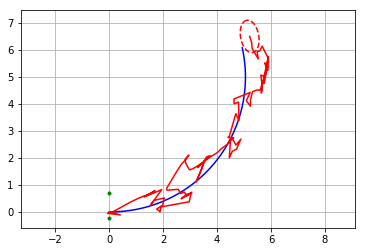

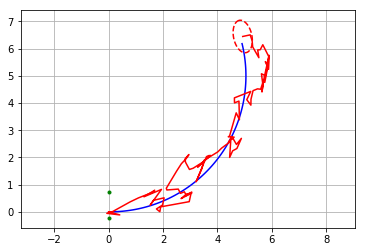

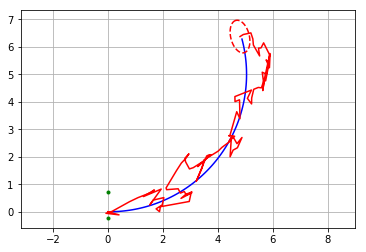

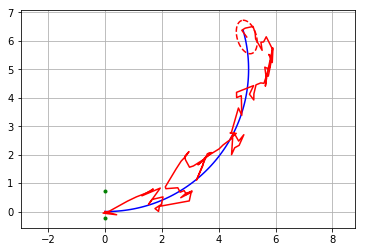

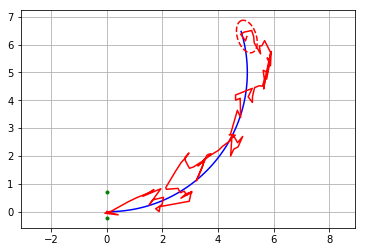

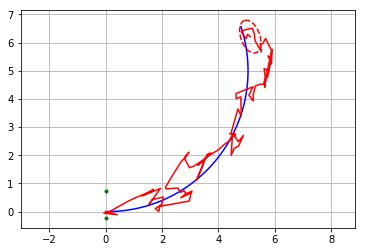

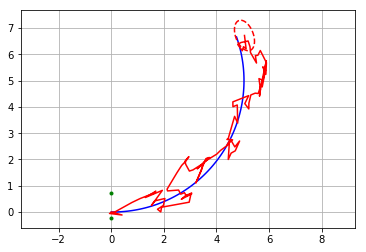

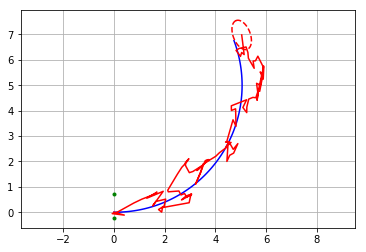

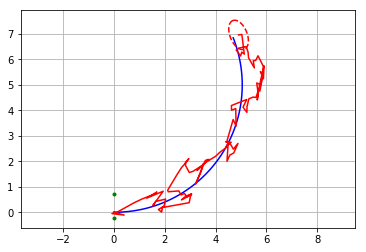

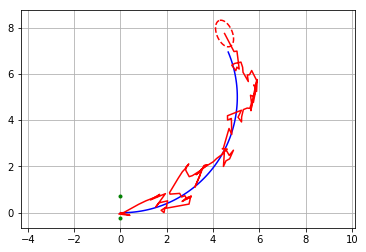

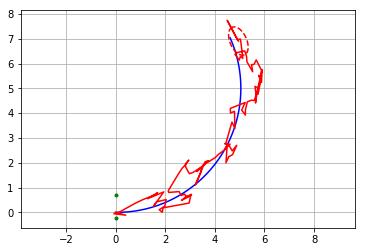

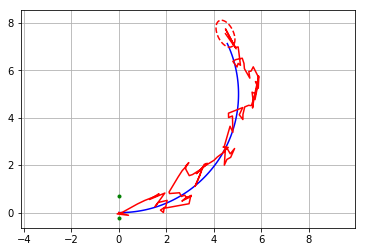

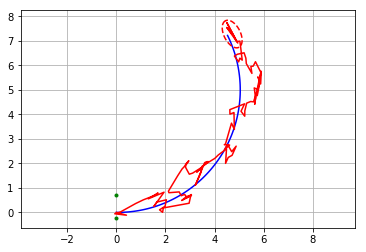

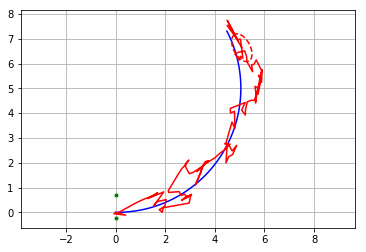

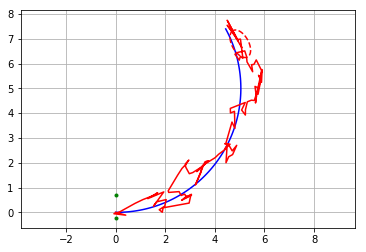

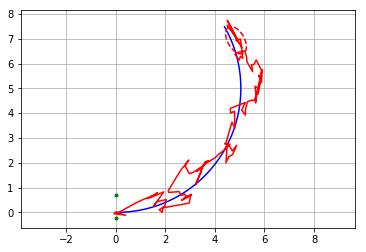

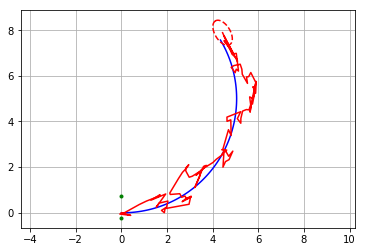

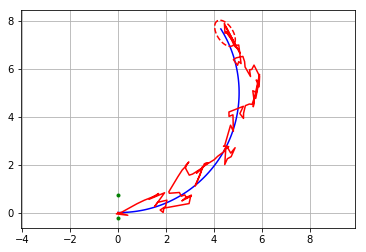

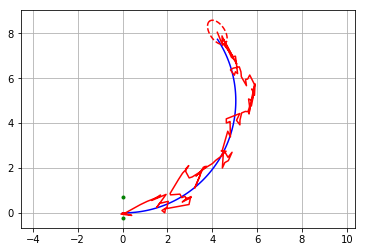

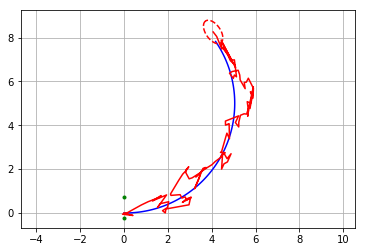

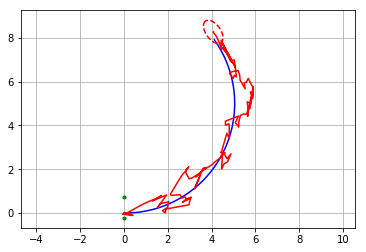

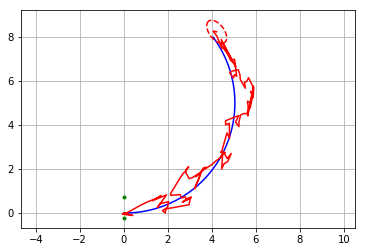

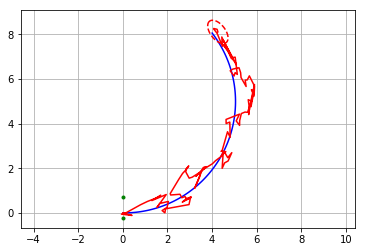

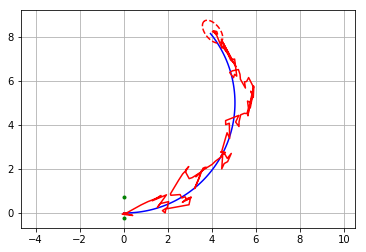

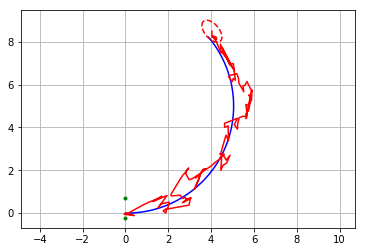

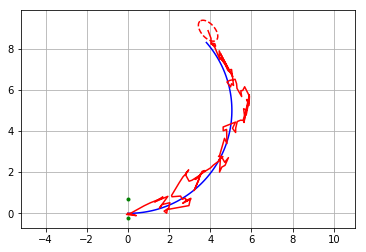

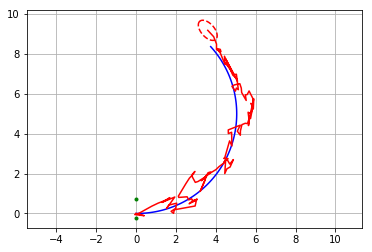

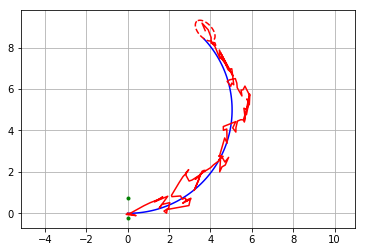

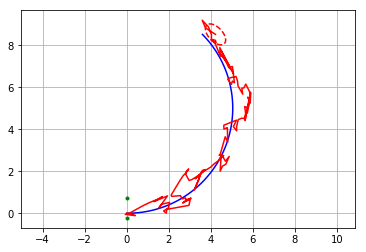

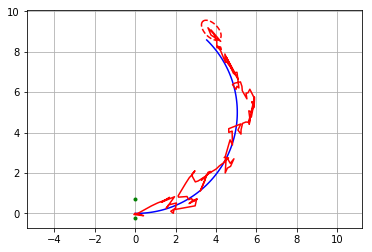

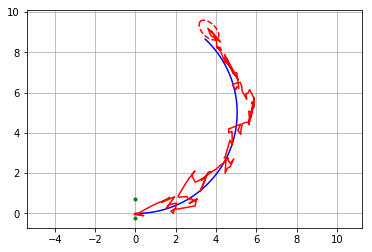

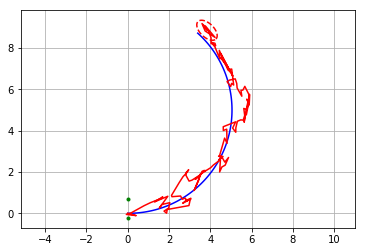

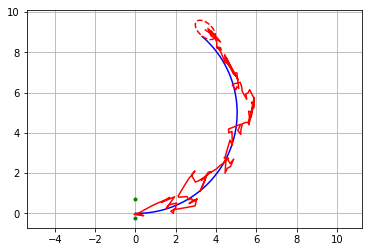

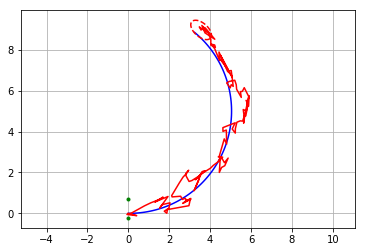

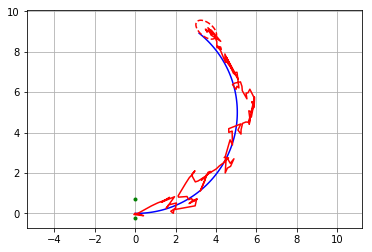

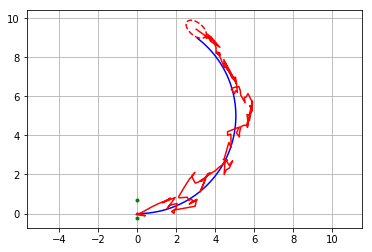

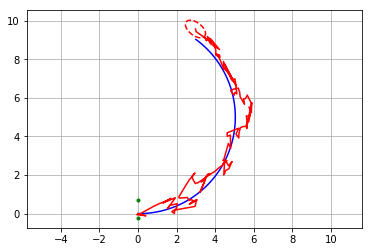

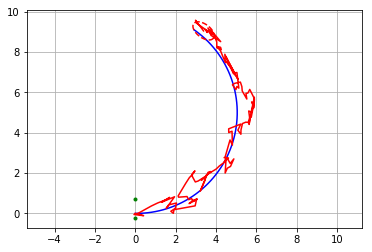

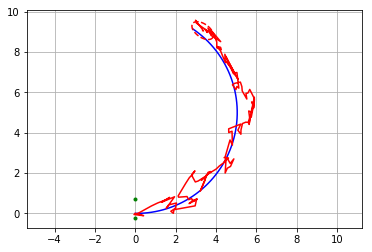

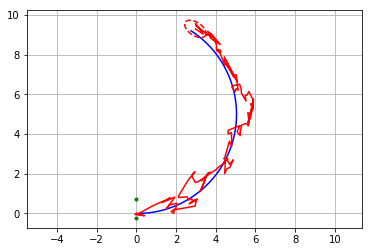

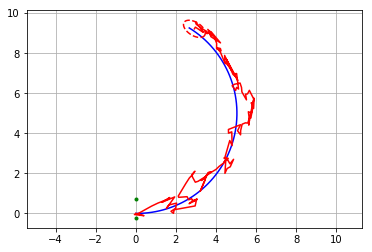

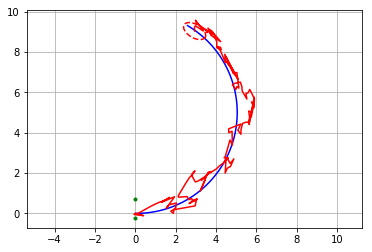

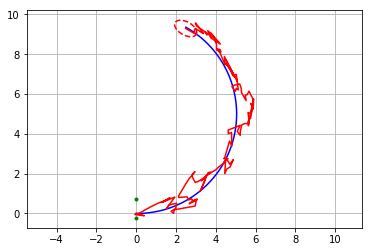

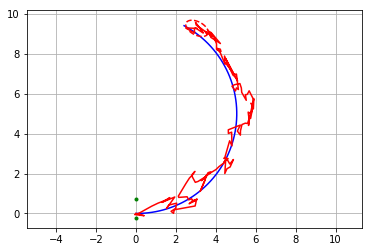

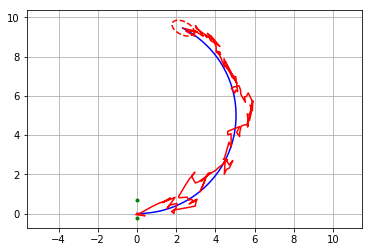

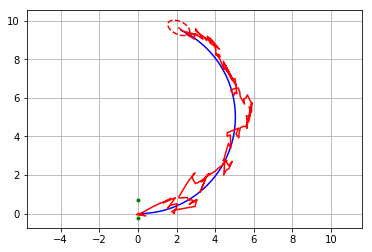

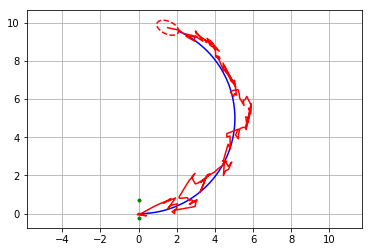

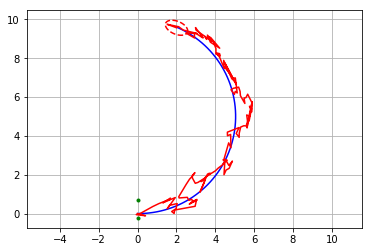

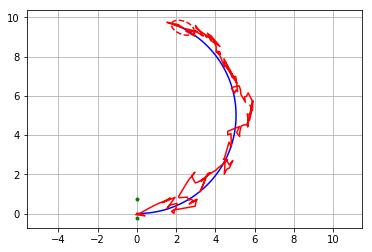

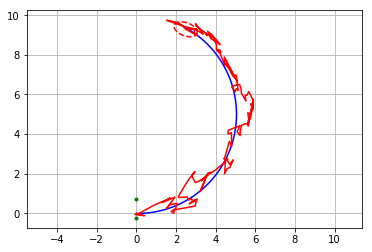

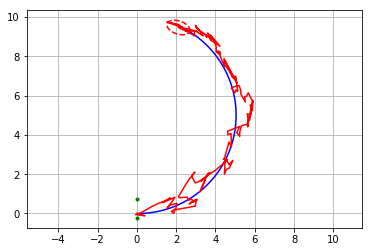

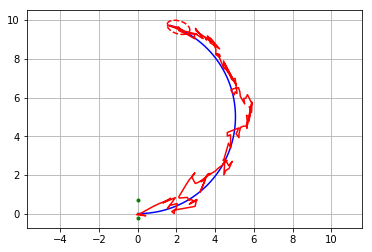

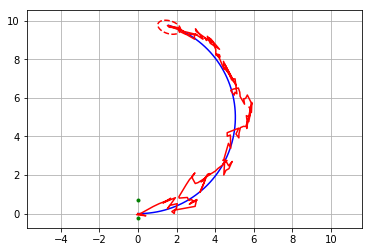

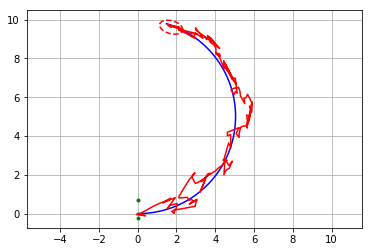

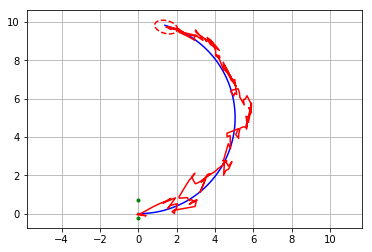

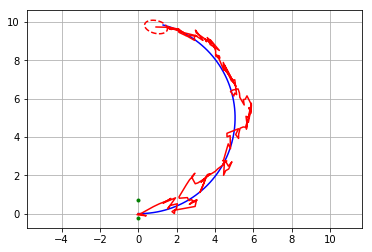

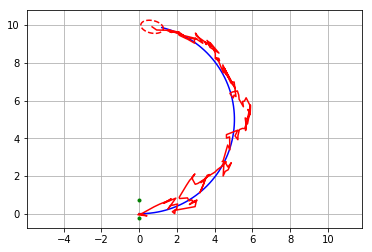

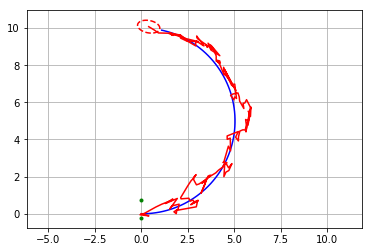

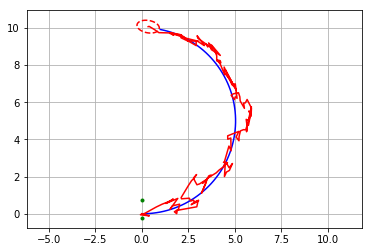

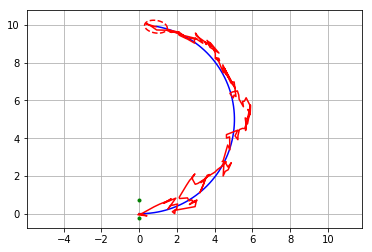

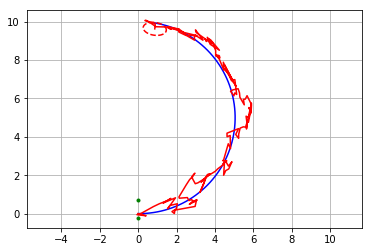

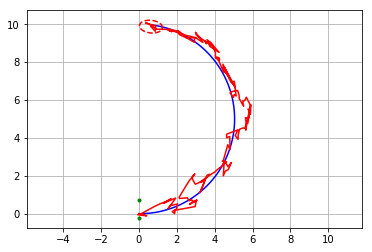

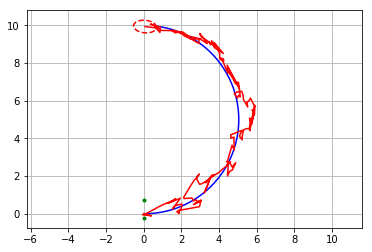

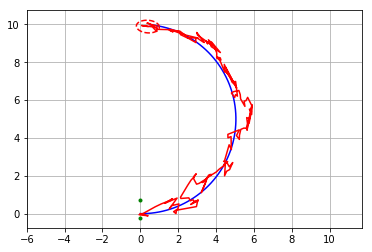

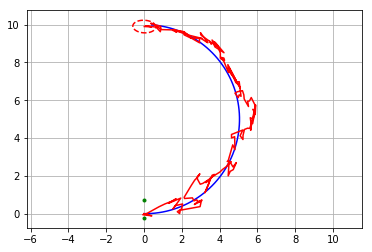

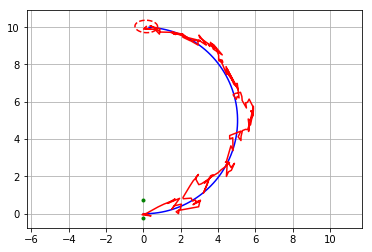

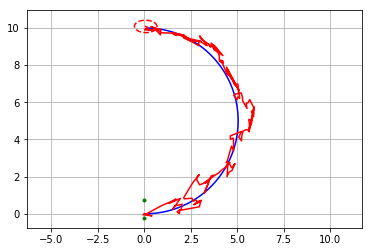

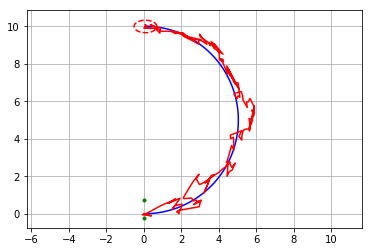

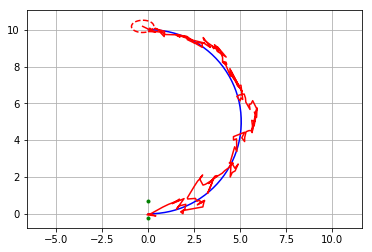

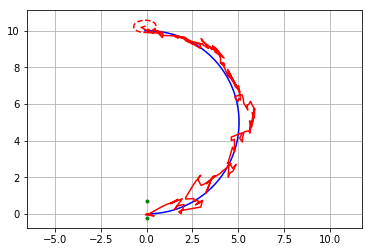

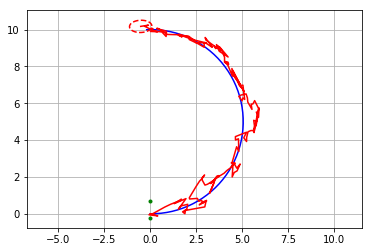

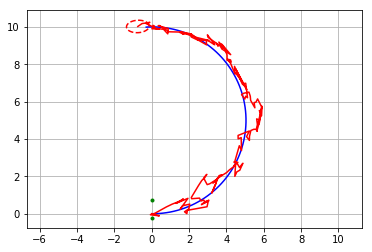

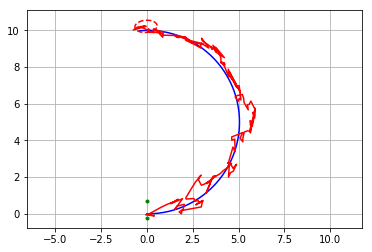

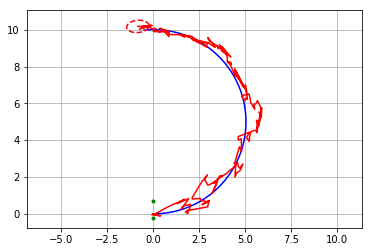

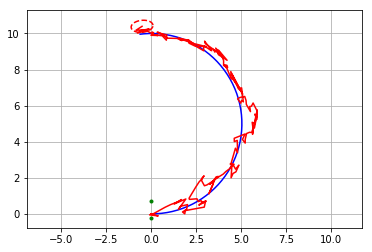

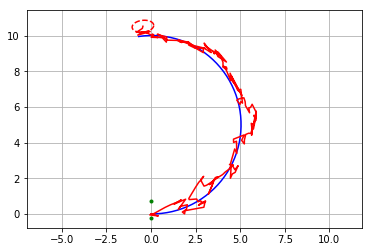

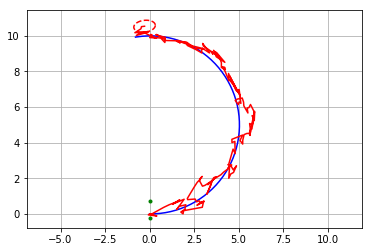

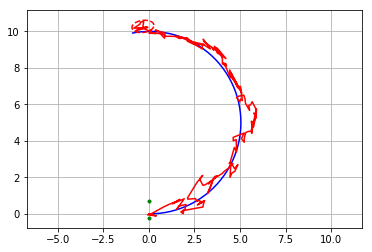

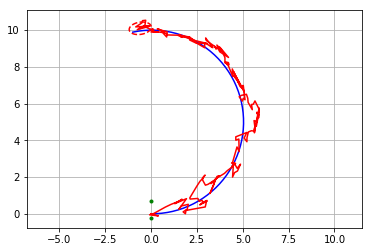

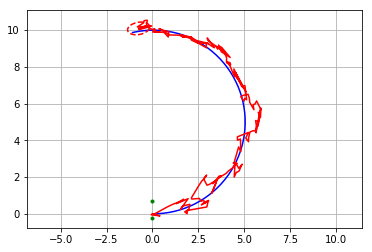

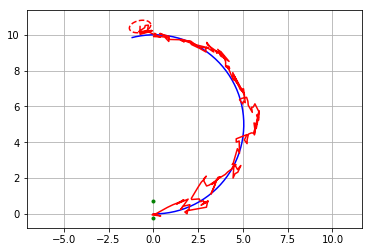

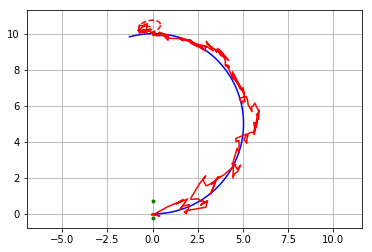

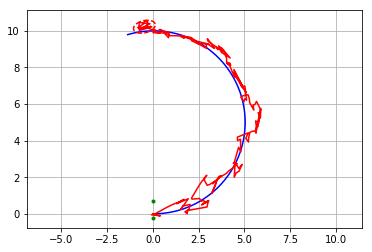

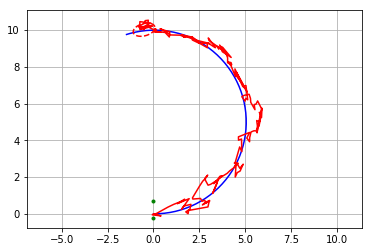

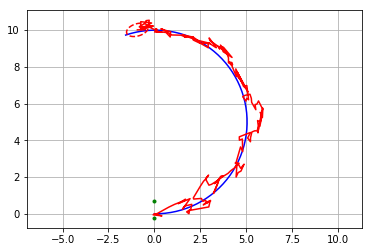

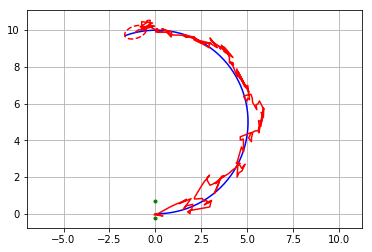

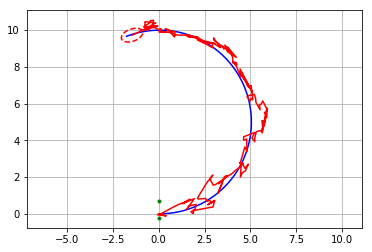

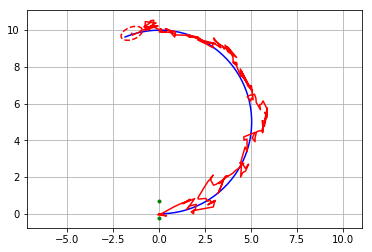

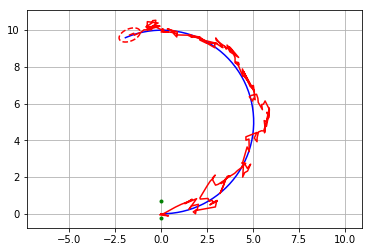

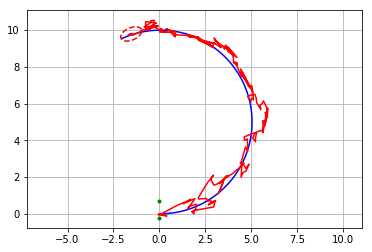

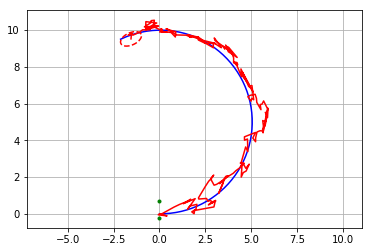

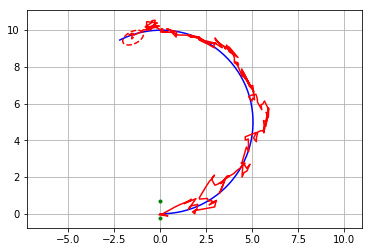

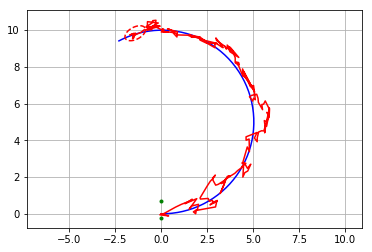

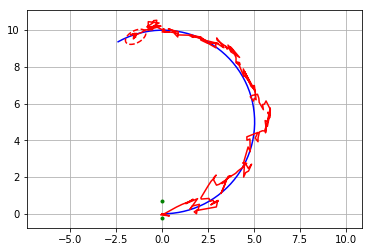

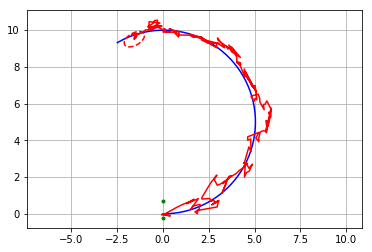

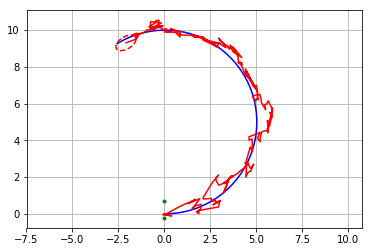

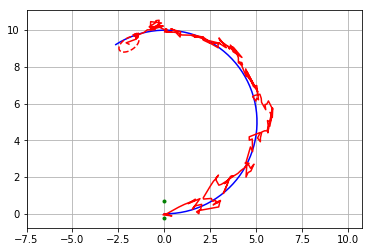

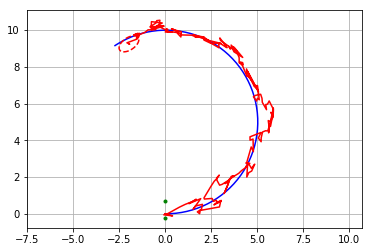

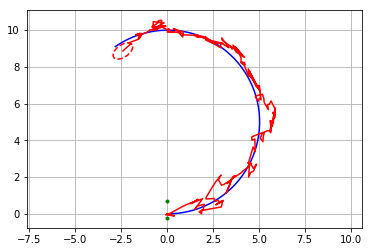

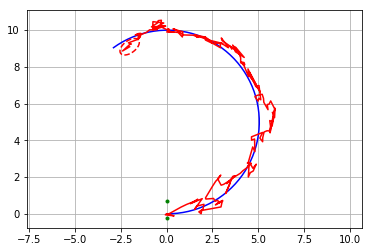

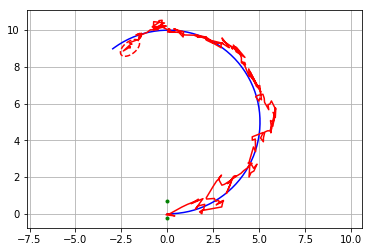

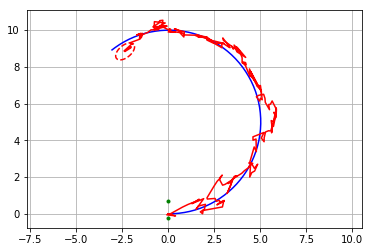

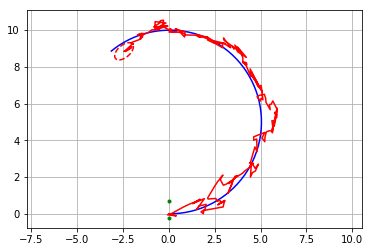

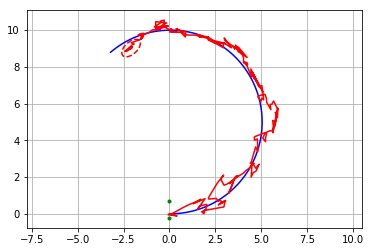

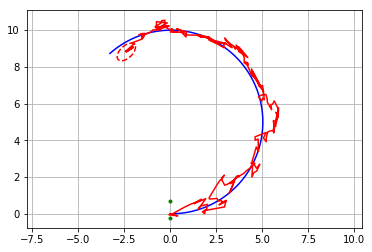

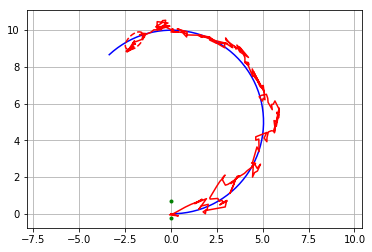

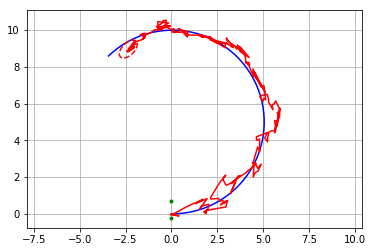

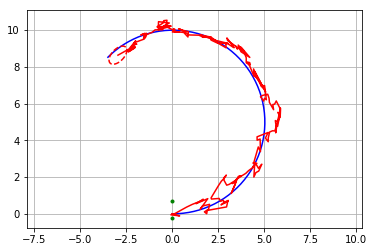

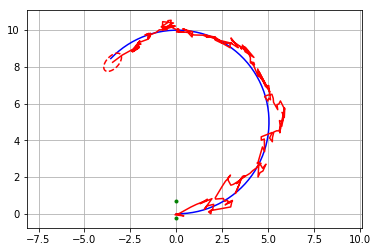

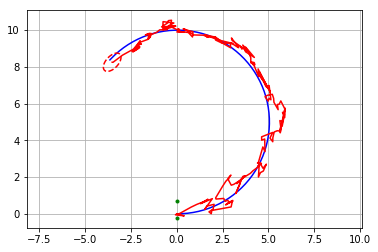

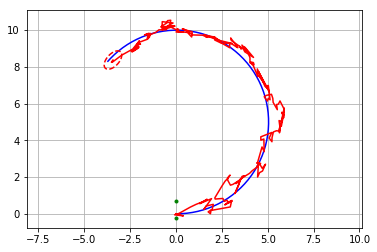

In [40]:
# Plotting in Jupyter notebook is somewhat problematic, since the plots are created at each new iteration.
# Desired behavior was to operate on a single figure which would dynamically show the execution of EKF.
# Python script ekf.py of this repository has that behavior.
import matplotlib.pyplot as plt
current_time = 0.0
fig = plt.figure()
while SIMULATION_TIME > current_time:
    current_time += delta_t
    true_state = motion_model(true_state,u)
    zx = true_state[0,0] + np.random.randn() + Qsim[0,0]
    zy = true_state[1,0] + np.random.randn() + Qsim[1,1]
    z = np.array([[zx,zy]]).T
    estimated_state_mean,estimated_state_covariance = ekf(estimated_state_mean,estimated_state_covariance,u,z)
    # store data history
    history_estimated_state = np.hstack((history_estimated_state, estimated_state_mean))
    history_true_state = np.hstack((history_true_state, true_state))
    history_measurements = np.hstack((history_measurements, z))
    
    plt.clf()
    plt.plot(history_measurements[:, 0], history_measurements[:, 1], ".g")
    plt.plot(history_true_state[0, :].flatten(),
             history_true_state[1, :].flatten(), "-b")
    plt.plot(history_estimated_state[0, :].flatten(),
             history_estimated_state[1, :].flatten(), "-r")
    
    plot_covariance_ellipse(estimated_state_mean, estimated_state_covariance)
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.001)